<h3> Auto Scaling makes dx0=dx1 : note that ASM for fresnel diffraction does not literally mean it's some kind of Fourier transforming - hence frequency space, etc. The point is that, accidentally mathematical formulas between exact Fresnel and angular spectrum Fresnel coincided, and by that, we can numerically calculate the diffraction much more efficiently </h3>

\begin{gather*}

(1)\  analytic form \\
U(x_1,y_1;z) = \frac{1}{i \lambda z}exp(i \frac{2\pi}{\lambda}z) exp(i \frac{\pi}{\lambda z} (x_1^2 + y_1^2)) \\
\times \int dx_0 dy_0 U(x_0,y_0;0) exp(i \frac{\pi}{\lambda z} (x_0^2 + y_0^2)) exp(-i \frac{2 \pi}{\lambda z} (x_0 x_1 + y_0 y_1)) \\
= A(x_1,y_1;z) \times \mathcal{F} [u,v] |_{u=\frac{x_1}{\lambda z}, v=\frac{y_1}{\lambda z}} \\
\\

(2)\  discrete form \\
x_0 \rightarrow x_{0m} \equiv (dx_0) \times (m-\frac{M}{2}) \\
y_0 \rightarrow y_{0n} \equiv (dy_0) \times (n-\frac{N}{2}) \\
\downarrow \\
x_1 \rightarrow x_{1p} \equiv (dx_1) \times (p-\frac{M}{2}) \\
y_1 \rightarrow y_{1q} \equiv (dy_1) \times (q-\frac{N}{2}) \\

\Downarrow \\

U(x_{1p}, y_{1q} ;z) = A(x_{1p}, y_{q1} ;z) \times \mathcal{F} [u_p,v_q] |_{u_p=\frac{x_{1p}}{\lambda z}, v_q=\frac{y_{1q}}{\lambda z}} \\

\end{gather*}

\begin{gather*}

with\ substition, \\
x_{1p} \rightarrow u_p \lambda z \\
y_{1q} \rightarrow v_q \lambda z \\
where \\
u_p=\frac{1}{M dx_0} (p-\frac{M}{2}) \ \ and \ \  v_q=\frac{1}{N dy_0} (q-\frac{N}{2}) \\
\downarrow \\
x_{1p} = \frac{\lambda z}{M dx_0} (p-\frac{M}{2}) \ \ and \ \  y_{1q}=\frac{\lambda z}{N dy_0} (q-\frac{N}{2}) \\

\Downarrow \\

U(\frac{\lambda z}{M dx_0} (p-\frac{M}{2}), \frac{\lambda z}{N dy_0} (q-\frac{N}{2}) ;z) \\
= \\
 A(\frac{\lambda z}{M dx_0} (p-\frac{M}{2}), \frac{\lambda z}{N dy_0} (q-\frac{N}{2}) ;z) \times \mathcal{F} [p,q]\\

\end{gather*}

\begin{gather*}

(*)\ auto\ scaling \\
\Delta x_0 \equiv \sqrt{\lambda z M} \ \ and \ \ \Delta y_0 \equiv \sqrt{\lambda z N} \\
\downarrow \\
dx_0 \equiv \sqrt{\frac{\lambda z}{M}} \ \ and \ \ dy_0 \equiv \sqrt{\frac{\lambda z} {N}} \\
\Downarrow \\
dx_1 \equiv u \lambda z = \sqrt{\frac{\lambda z}{M}} \ \ and \ \ dy_1 \equiv v \lambda z = \sqrt{\frac{\lambda z} {N}}
\\
\Downarrow \\
hence, \\
dx_0 = dx_1 \ \ and \ \ dy_0 = dy_1 \\
x_0[m] = x_1[m] \ \ and \ \ y_0[n] = y_1[n]
\end{gather*}

<h3> both satisfying image and sampling conditions </h3>

<h3>
note : already, F[u_p, v_q] = F[p, q] by FFT algorithm
</h3>

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import wave, propagator, utils
import cv2

m = 1
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

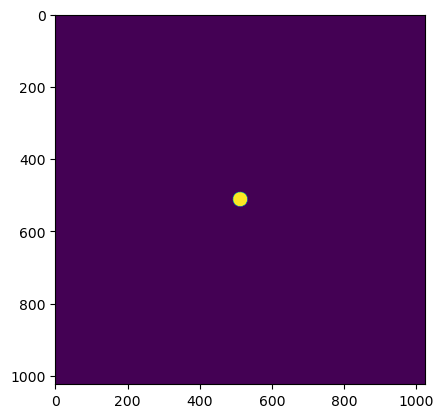

In [11]:
a = np.zeros((1024, 1024))
x = np.arange(-512, 512)
y = np.arange(-512, 512)
X, Y = np.meshgrid(x, y)
a[X**2+Y**2<=400] = 1
plt.imshow(a)

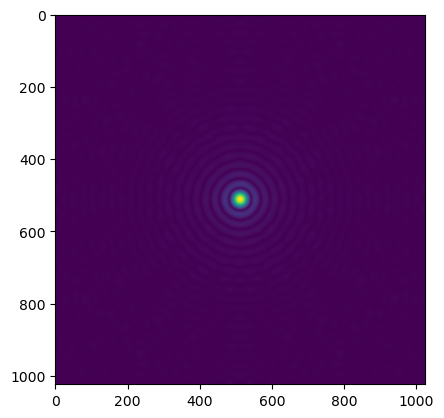

In [12]:
prop, _ = propagator.Fresnel_propagator.propagate(633*nm, 1*m, a, 10*um)
plt.imshow(np.abs(prop))

In [7]:
# prepare an image
a = Image.open('animal.jpg').convert('L')
a = np.array(a)
a = utils.Padder.pad_image(a)
a = (a - a.min())/(a.max() - a.min())

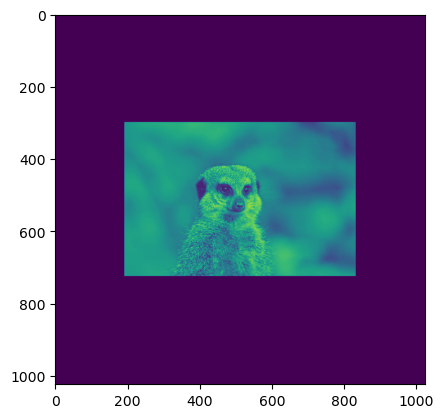

In [8]:
plt.imshow(a)

2.060546875e-05


Text(0.5, 0, 'resolution : (20.60546875um)')

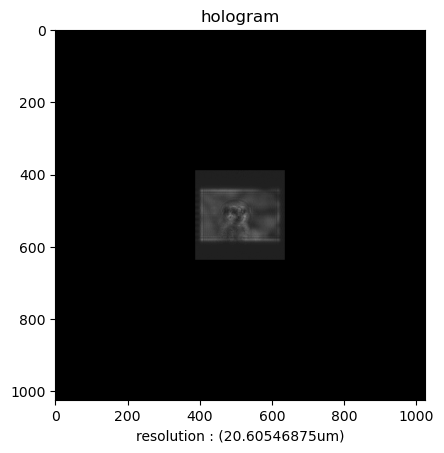

In [10]:
source = a.copy()
lam = 633*nm
z0 = 1*m
N = source.shape[0]
source_res = 30*um
theta = np.pi/5

fresnel, hologram_res = propagator.Fresnel_propagator.propagate(lam=lam, z=z0, source=source, source_resolution=source_res)
reference_wave = wave.Plane_wave_generator.get_wave(shape=source.shape, lam=lam, resolution=source_res, theta=theta)
hologram = fresnel + 0.5 * reference_wave
hologram = np.abs(hologram)**2

# resolution fitting : 이게 맞나...?
dmd_res = 5*um
res_ratio = dmd_res/hologram_res
if res_ratio < 1:
    hologram = cv2.resize(hologram, dsize=(0,0), fx=res_ratio, fy=res_ratio)
else:
    raise NotImplementedError('resolution reduction is not implemented yet')

# place center
h, w = hologram.shape
temp = np.zeros((N, N))
shift_h, shift_w = (N-h)//2, (N-w)//2
temp[0:h, 0:w] = hologram
temp = np.roll(temp, shift=shift_h, axis=0)
temp = np.roll(temp, shift=shift_w, axis=1)
hologram = temp

print(hologram_res)
plt.imshow(hologram, 'gray')
plt.title('hologram')
plt.xlabel('resolution : (' + str(hologram_res/um) + 'um)')

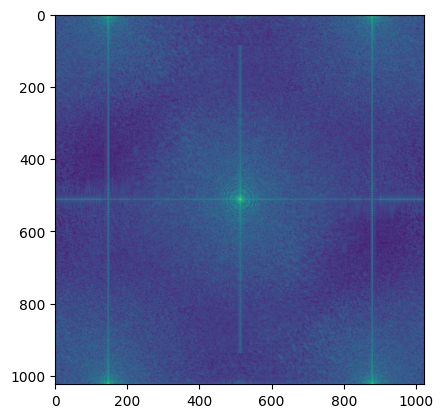

In [4]:
plt.imshow(np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(hologram)))))

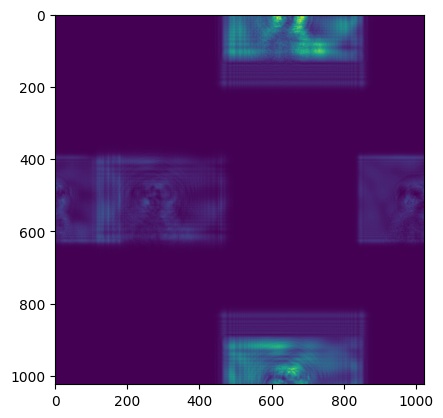

In [5]:
# Reconstruction
source = hologram.copy()
source = (source - source.min())/(source.max() - source.min())
lam = 633*nm
z0 = 0.1*m
N = source.shape[0]
source_res = 5*um
theta = np.pi/5

reference_wave = wave.Plane_wave_generator.get_wave(shape=source.shape, lam=lam, resolution=source_res, theta=theta)
U = source * reference_wave

recon, recon_res = propagator.Fresnel_propagator.propagate(lam=lam, z=z0, source=U, source_resolution=source_res)
recon = np.fft.ifftshift(recon)
recon = np.abs(recon)**2
plt.imshow(recon)